In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Continuous Tempering Langevin")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim
save_directory = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


2024-03-18 10:31:49.773720: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Numpyro intro

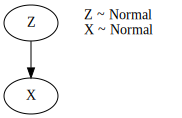

In [3]:
import numpyro.distributions as dist

def model():
    z = sample('Z', dist.Normal(0, 1))
    # z2 = deterministic('z2', z**2)
    z2 = z**2
    # debug.print("hey z2={z2}", z2=z2)
    x = sample('X', dist.Normal(z2, 1))
    return x

numpyro.render_model(model, render_distributions=True)

In [4]:
from numpyro.infer.util import log_density
from numpyro.handlers import seed, condition, trace

x_sample = dict(X=seed(model, 0)())
obs_model = condition(model, x_sample)
logp = lambda z: log_density(obs_model, (), {}, {'Z':z})[0]

from jax import grad
score = grad(logp)

In [5]:
log_density(obs_model, (), {}, {'Z':2})

(Array(-8.398987, dtype=float32),
 OrderedDict([('Z',
               {'type': 'sample',
                'name': 'Z',
                'fn': <numpyro.distributions.continuous.Normal at 0x7fff84235ad0>,
                'args': (),
                'kwargs': {'rng_key': None, 'sample_shape': ()},
                'value': 2,
                'scale': None,
                'is_observed': False,
                'intermediates': [],
                'cond_indep_stack': [],
                'infer': {}}),
              ('X',
               {'type': 'sample',
                'name': 'X',
                'fn': <numpyro.distributions.continuous.Normal at 0x7ffff035f4d0>,
                'args': (),
                'kwargs': {'rng_key': None, 'sample_shape': ()},
                'value': Array(0.97969896, dtype=float32),
                'scale': None,
                'is_observed': True,
                'intermediates': [],
                'cond_indep_stack': [],
                'infer': {}})]))

In [10]:
kernel = numpyro.infer.NUTS(obs_model, step_size=1e-2)
mcmc =  numpyro.infer.MCMC(kernel, num_warmup=0, num_samples=2, num_chains=3, chain_method='vectorized', progress_bar=True)
mcmc.run(jr.PRNGKey(42), extra_fields=['num_steps'])
samples = mcmc.get_samples()
extra = mcmc.get_extra_fields()
samples.update(extra)

sample: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


In [11]:
mcmc.last_state

HMCState(i=Array([2, 2, 2], dtype=int32), z={'Z': Array([-1.1576025 ,  0.02454335,  0.39629778], dtype=float32)}, z_grad={'Z': Array([-1.9918745 , -0.02351727, -0.25572863], dtype=float32)}, potential_energy=Array([2.572823 , 2.3174932, 2.254777 ], dtype=float32), energy=Array([4.6253414, 3.299024 , 4.903417 ], dtype=float32), r=None, trajectory_length=None, num_steps=Array([183, 143, 183], dtype=int32), accept_prob=Array([0.9999781, 0.9999842, 0.9997975], dtype=float32), mean_accept_prob=Array([0.9999888, 0.9999735, 0.9998973], dtype=float32), diverging=Array([False, False, False], dtype=bool), adapt_state=HMCAdaptState(step_size=Array([0.01, 0.01, 0.01], dtype=float32), inverse_mass_matrix={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, mass_matrix_sqrt={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, mass_matrix_sqrt_inv={('Z',): Array([[1.],
       [1.],
       [1.]], dtype=float32)}, ss_state=(Array([0., 0., 0.], dtype=float32), Array([0., 0., 0.

In [ ]:
plt.figure(figsize=(12,8))
zs = jnp.linspace(-2,2,1000)
logps = jnp.exp(vmap(logp)(zs))
plt.plot(zs, logps / logps.mean() / 4, color='tab:red', linewidth=10)
plt.hist(samples['Z'], density=True, color='tab:orange', alpha=0.7, bins=20)
plt.ylim(0,0.42)
plt.axis('off')
plt.tight_layout()

In [35]:
np.bincount(samples['num_steps']), samples['num_steps'].sum()

(array([0, 1, 1, 1]), Array(6, dtype=int32))

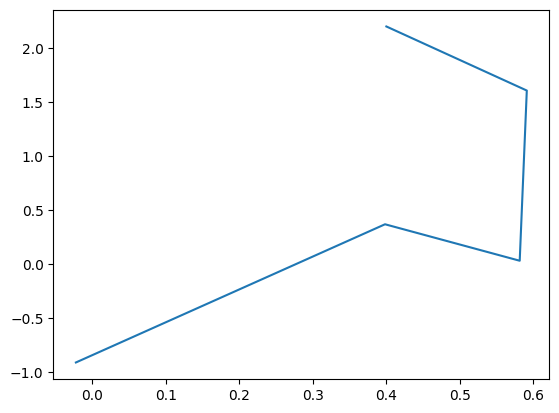

In [30]:
from matplotlib import rc
rc('animation', html='html5')
from matplotlib.animation import FuncAnimation
x, y = np.random.randn(2,10,5)

plt.figure()
line, = plt.plot(x[0], y[0])

def update(i):
    line.set_data(x[i], y[i])

anim = FuncAnimation(plt.gcf(), update, frames=10)
display(anim)
# anim.save("anim.mp4") # or .gif

## Numpyro tests 

### No delta dist.

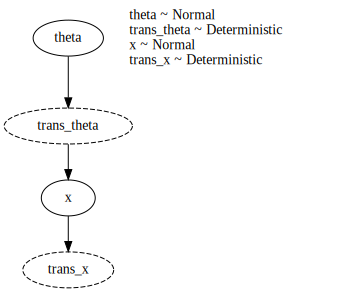

In [31]:
def forward_test():
    theta = numpyro.sample("theta", dist.Normal(0, 1))
    trans_theta = numpyro.deterministic('trans_theta', 2*theta**2 + 1)
    x = numpyro.sample('x', dist.Normal(trans_theta, 0.001**2))  
    trans_x = numpyro.deterministic('trans_x', 2*x**2 + 1)
    return trans_x

numpyro.render_model(
    model=forward_test,
    render_distributions=True,
    render_params=True,)

In [32]:
def testtruc(sample_size):
    with numpyro.plate("testruc", sample_size):
        return forward_test()


test = seed(testtruc, 0)
test_trace = trace(test).get_trace()
test_trace, test()

(OrderedDict([('testruc',
               {'type': 'plate',
                'fn': <function numpyro.primitives._subsample_fn(size, subsample_size, rng_key=None)>,
                'name': 'testruc',
                'args': (5, None),
                'kwargs': {'rng_key': None},
                'value': Array([0, 1, 2, 3, 4], dtype=int32),
                'scale': 1.0,
                'cond_indep_stack': []}),
              ('theta',
               {'type': 'sample',
                'name': 'theta',
                'fn': <numpyro.distributions.distribution.ExpandedDistribution at 0x7fffa0112db0>,
                'args': (),
                'kwargs': {'rng_key': Array([2718843009, 1272950319], dtype=uint32),
                 'sample_shape': ()},
                'value': Array([-1.4581939, -2.047044 ,  2.0473392,  1.1684095, -0.9758364],      dtype=float32),
                'scale': None,
                'is_observed': False,
                'intermediates': [],
                'cond_indep_

In [250]:
from numpyro.infer import log_likelihood
from numpyro.infer.util import log_density

f_trace = trace(seed(forward_test, 0)).get_trace()
other_test = seed(forward_test, 0)
print(f_trace['trans_x']['value'], other_test(), other_test())
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

26.148918 26.148918 6.7153955
{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': Array(3.5460484, dtype=float32), 'trans_x': Array(26.148918, dtype=float32)}


(Array(-2.7931314, dtype=float32), Array(-2.7931314, dtype=float32))

In [251]:
cond_test = condition(forward_test, {'x':-1})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': -1, 'trans_x': 3}


(Array(-15.793351, dtype=float32), Array(-15.793351, dtype=float32))

In [252]:
cond_test = condition(forward_test, {'trans_x':-1})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': Array(3.5460484, dtype=float32), 'trans_x': Array(26.148918, dtype=float32)}


(Array(-2.7931314, dtype=float32), Array(-2.7931314, dtype=float32))

### Delta dist.

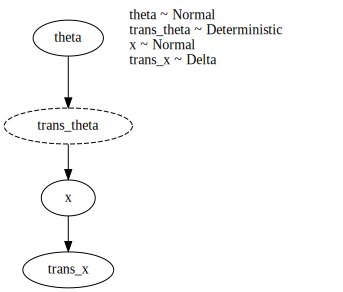

In [275]:
def forward_test():
    theta = numpyro.sample("theta", dist.Normal(0, 1))
    trans_theta = numpyro.deterministic('trans_theta', 2*theta**2 + 1)
    x = numpyro.sample('x', dist.Normal(trans_theta, 1))  
    trans_x = numpyro.sample('trans_x', dist.Delta(2*x**2 + 1))
    return trans_x

numpyro.render_model(
    model=forward_test,
    render_distributions=True,
    render_params=True,)

In [276]:
f_trace = trace(seed(forward_test, 0)).get_trace()
other_test = seed(forward_test, 0)
print(f_trace['trans_x']['value'], other_test(), other_test())
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

26.148918 26.148918 1.3972381
{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': Array(3.5460484, dtype=float32), 'trans_x': Array(26.148918, dtype=float32)}


(Array(-2.7931314, dtype=float32), Array(-2.7931314, dtype=float32))

In [277]:
cond_test = condition(forward_test, {'x':-1})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': -1, 'trans_x': Array(3, dtype=int32, weak_type=True)}


(Array(-15.793351, dtype=float32), Array(-15.793351, dtype=float32))

In [278]:
cond_test = condition(forward_test, {'trans_x':-1})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': Array(3.5460484, dtype=float32), 'trans_x': -1}


(Array(-2.7931314, dtype=float32), Array(-inf, dtype=float32))

In [279]:
cond_test = condition(forward_test, {'trans_x':2*3.5460484**2+1})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(samples['x']) + f_trace['theta']['fn'].log_prob(samples['theta']), log_density(forward_test, (), {}, samples)[0]

{'theta': Array(-1.2515389, dtype=float32), 'trans_theta': Array(4.132699, dtype=float32), 'x': Array(3.5460484, dtype=float32), 'trans_x': 26.14891851028512}


(Array(-2.7931314, dtype=float32), Array(-2.7931314, dtype=float32))

In [ ]:
nuts_kernel = numpyro.infer.NUTS(
        model=observed_model,)

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=500,
       num_samples=1000,
       # chain_method="parallel", num_chains=8,
       # thinning=2,
       progress_bar=True)

mcmc.run(random.PRNGKey(0), box_size, mesh_size)
res = mcmc.get_samples()
np.save("./to_del_samples", res)

In [5]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
import jax
import jax.numpy as jnp

def model():
    a = numpyro.sample('a', dist.Normal(0, 1))
    b = numpyro.sample('b', dist.Normal(0, 1))
    c = 2 * a + b
    # numpyro.sample('obs', dist.Delta(c, event_dim=0), obs=jnp.array(3.0))  # deterministically transformed variable with observed value
    numpyro.sample('obs', dist.Normal(c, 0.001), obs=jnp.array(3.0))  

# Use MCMC for inference with custom initialization
nuts_kernel = NUTS(model, init_strategy=init_to_value(values={'a': 1.0, 'b': 1.0}))
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(0))

# Get samples and transformed variable values
samples = mcmc.get_samples()
transformed_c_samples = 2 * samples['a'] + samples['b']

# Print or use the transformed variable samples as needed
print(transformed_c_samples)


sample: 100%|██████████| 1500/1500 [04:28<00:00,  5.60it/s, 1023 steps of size 8.85e-04. acc. prob=0.93]


[2.9996488 3.0003428 2.9994917 3.0010507 2.9990392 3.0008206 3.001339
 2.9998553 3.0008283 3.0008283 2.997068  2.9989204 3.0004332 2.999815
 2.9991686 3.0011063 2.9995055 3.0004783 3.0003233 3.0009353 3.000266
 3.0002806 3.0010421 3.0000415 3.0001662 3.0003161 3.0006728 3.0006893
 2.9985323 2.999494  3.0010614 2.998889  2.9996538 3.0002337 2.9997659
 3.001271  2.998671  3.0011427 2.9996893 3.0001142 2.9993882 3.0007744
 3.0007744 3.0012856 2.9988952 3.0009587 2.9988663 2.9997947 3.0001104
 3.0012126 3.000443  2.9987898 3.0010676 2.9988236 3.0009947 3.0005817
 3.000293  2.9992204 2.9992328 2.9979184 3.001119  2.9988823 2.9993196
 2.9996984 3.0009694 3.0001407 3.0004911 2.999165  3.000846  3.0005212
 3.0005202 3.001202  2.9976122 3.0022354 2.99882   3.0002818 2.9999866
 3.0005953 3.0003247 2.998356  3.0016413 2.998612  2.9990754 3.001049
 3.0010123 3.0004854 3.000576  2.9993076 3.00076   3.0028086 2.9998686
 3.0005155 3.0005774 2.9995315 2.9991195 2.998974  3.0008764 2.9993627
 2.9986384


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.28      0.44      1.29      0.67      2.03     16.17      1.06
         b      0.44      0.88      0.42     -1.07      1.66     16.17      1.06

Removed no burn in


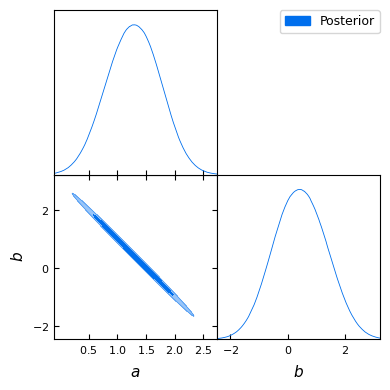

In [6]:
numpyro.diagnostics.print_summary({key: samples[key][None] for key in samples} )
samples_arr= np.array([samples[key] for key in samples]).T
samples2 = MCSamples(samples=samples_arr, names=list(samples.keys()), labels=list(samples.keys()))
%matplotlib inline
g = plots.get_subplot_plotter()
g.triangle_plot(samples2, filled=True, legend_labels = ['Posterior'])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.00      0.00      1.00      1.00      1.00       nan       nan
         b      1.00      0.00      1.00      1.00      1.00      0.69      1.00

Removed no burn in


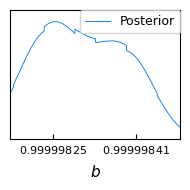

In [ ]:
numpyro.diagnostics.print_summary({key: samples[key][None] for key in samples} )
samples_arr= np.array([samples[key] for key in samples]).T
samples2 = MCSamples(samples=samples_arr, names=list(samples.keys()), labels=list(samples.keys()))
%matplotlib inline
g = plots.get_subplot_plotter()
g.triangle_plot(samples2, filled=True, legend_labels = ['Posterior'])

### square model

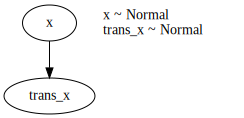

In [80]:
from numpyro.infer.util import log_density

def forward_test():
    x = numpyro.sample('x', dist.Normal(0, 1))  
    # trans_x = numpyro.sample('trans_x', dist.Delta(x**2))
    trans_x = numpyro.sample('trans_x', dist.Normal(jnp.sin(5*x), 1e-1)) # 1e-45
    return trans_x

numpyro.render_model(
    model=forward_test,
    render_distributions=True,
    render_params=True,)

In [104]:
cond_test = condition(forward_test, {'trans_x':0.5})
f_trace = trace(seed(cond_test, 0)).get_trace()
samples = {name: f_trace[name]['value'] for name in f_trace}
print(samples)
f_trace['x']['fn'].log_prob(2) + f_trace['trans_x']['fn'].log_prob(2), log_density(cond_test, (), {}, samples)[0]

{'x': Array(-1.2515389, dtype=float32), 'trans_x': 0.5}


(Array(-196.47012, dtype=float32), Array(-11.576533, dtype=float32))

In [ ]:
from numpyro.infer import Predictive

predictive = Predictive(forward_test, num_samples=2)
y_pred = predictive(random.PRNGKey(0))
y_pred, log_density(forward_test, (), {}, y_pred)[0]

({'trans_x': Array([0.34416375, 1.6300184 ], dtype=float32),
  'x': Array([-0.58665055,  1.2767134 ], dtype=float32)},
 Array(15.966927, dtype=float32))

In [107]:
%matplotlib inline
box_corner = 1.5
box = np.array([[-box_corner,box_corner], [-box_corner,box_corner]])
xx, yy = np.mgrid[[slice(box_ax[0],box_ax[1],50*1j) 
                       for box_ax in box]] # to get distances
zz = jnp.array([[log_density(forward_test, (), {}, {'x':xx_ij, 'trans_x':yy_ij})[0] for xx_ij, yy_ij in zip(xx_i, yy_i)] for xx_i, yy_i in zip(xx, yy)])
print(zz.shape)

(50, 50)


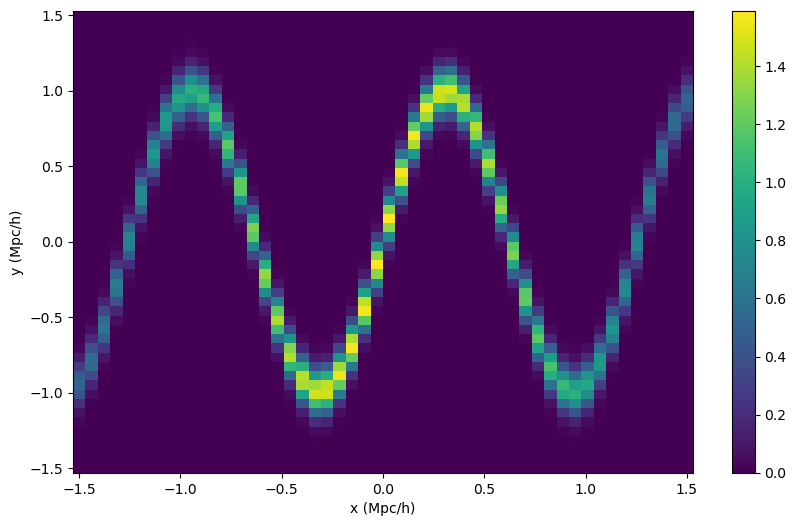

In [108]:
plt.figure(figsize=(10,6))
ax3D = plt.subplot(111)
p3d = ax3D.pcolormesh(xx, yy, jnp.exp(zz), cmap='viridis')
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)")
plt.colorbar(p3d)
plt.show();

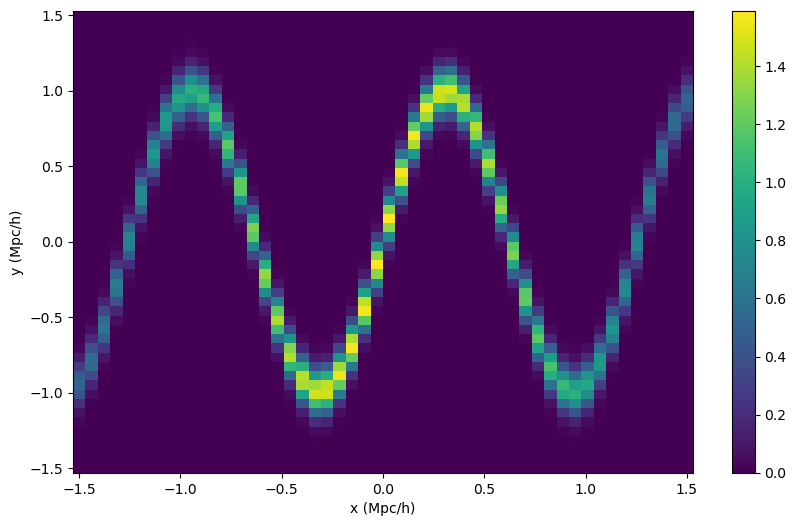

In [ ]:
plt.figure(figsize=(10,6))
ax3D = plt.subplot(111)
p3d = ax3D.pcolormesh(xx, yy, jnp.exp(zz), cmap='viridis')
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)")
plt.colorbar(p3d)
plt.show();

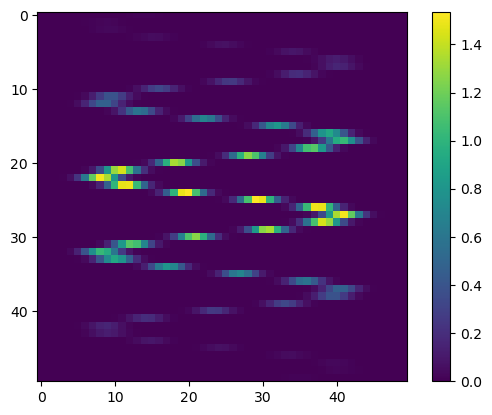

In [100]:
plt.imshow(jnp.exp(zz))
plt.colorbar();

## Plate

In [ ]:
# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size, dim=-3) as ind:
        # cosmo_prior()
        print(ind)
        numpyro.sample('truc', dist.Normal(np.zeros((2)), np.ones((2))) )

plate_size = 5
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 1)).get_trace(plate_size)

## Jax if

In [ ]:
from functools import partial
def truc(a=0):
    if a==0:
        print("hey")
    else:
        print("ho")

truc_part_jit = jax.jit(partial(truc, a=1))
truc_jit = jax.jit(truc)

In [ ]:
truc_part_jit(), truc_jit()

ho


In [ ]:
truc_jit(a=1)

# Other test

In [4]:
var = np.array([0.15829644, 0.31043825])
var * np.array([0.2, 0.14])